# Global Superstore SQL Project

This project is based on the Global Superstore dataset, available on Kaggle:  
https://www.kaggle.com/datasets/apoorvaappz/global-super-store-dataset  

The goal of this notebook is to demonstrate SQL and data analysis skills by running analytical queries on a MySQL database to extract business insights.
In addition, clustering models (K-Means and DBSCAN) were applied to segment customers and detect anomalies in purchasing behavior.

The workflow includes:
- Connecting to the MySQL database and using existing tables
- Writing SQL queries to answer business questions
- Summarizing insights from the queries
- Applying clustering models (K-Means, DBSCAN) for advanced customer segmentation

In [11]:
!python -m pip install --upgrade pip

# Install necessary packages for MySQL connection and data manipulation
!pip install mysql-connector-python sqlalchemy pymysql pandas

In [40]:
#imports:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
from getpass import getpass
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [13]:
# Prompt user for MySQL credentials and set database connection parameters
username = input("Enter username: ")
password = getpass("Enter password: ")
database = "Superstore"
host = "localhost"

# Create SQLAlchemy engine for connecting to MySQL database
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

# Try connecting and fetching a small query to test
try:
    test_df = pd.read_sql("SELECT 1", engine)
    print("Connection successful!")
except Exception as e:
    print("Connection failed! Check username or password.")
    print(f"Error details: {e}")

Enter username:  root
Enter password:  ········


Connection successful!


## Database Setup

Load and Explore the Customers Table from the Global Superstore Database

In [14]:
# Load all records from the Customers table into a pandas DataFrame
df_customers = pd.read_sql("SELECT * FROM Customers", engine)

# Display the first few rows of the Customers DataFrame
df_customers.head()

,CustomerID,CustomerName,Segment,City,State,Country,PostalCode,Market,Region
0,AA-10315,Alex Avila,Consumer,New York City,New York,United States,10011,US,East
1,AA-10375,Allen Armold,Consumer,Providence,Rhode Island,United States,2908,US,East
2,AA-10480,Andrew Allen,Consumer,Detroit,Michigan,United States,48234,US,Central
3,AA-10645,Anna Andreadi,Consumer,Oklahoma City,Oklahoma,United States,73120,US,Central
4,AA-315,Alex Avila,Consumer,Kaspiysk,Dagestan,Russia,None,EMEA,EMEA


In [15]:
# Reset the index
df_customers.reset_index(drop=True, inplace=True)

In [16]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    1590 non-null   object
 1   CustomerName  1590 non-null   object
 2   Segment       1590 non-null   object
 3   City          1590 non-null   object
 4   State         1590 non-null   object
 5   Country       1590 non-null   object
 6   PostalCode    793 non-null    object
 7   Market        1590 non-null   object
 8   Region        1590 non-null   object
dtypes: object(9)
memory usage: 111.9+ KB


In [17]:
#To see how the data is distributed
df_customers.describe()

,CustomerID,CustomerName,Segment,City,State,Country,PostalCode,Market,Region
count,1590,1590,1590,1590,1590,1590,793,1590,1590
unique,1590,795,3,611,327,74,305,5,9
top,ZD-21925,Zuschuss Donatelli,Consumer,New York City,California,United States,10024,US,EMEA
freq,1,2,818,64,172,793,19,793,420


In [18]:
#Checking how many nulls in each column
df_customers.isna().sum()

CustomerID        0
CustomerName      0
Segment           0
City              0
State             0
Country           0
PostalCode      797
Market            0
Region            0
dtype: int64

In [19]:
#This is to see the exact pronunciation of each column name
df_customers.columns

Index(['CustomerID', 'CustomerName', 'Segment', 'City', 'State', 'Country',
       'PostalCode', 'Market', 'Region'],
      dtype='object')

In [20]:
#Checking for duplicated rows
df_customers[df_customers.duplicated()]

,CustomerID,CustomerName,Segment,City,State,Country,PostalCode,Market,Region


## Analytical Queries

In this section, we explore the dataset using SQL queries to answer different business questions.  
Each query is preceded by a short description of what it analyzes.

In [21]:
# SQL query to aggregate total profit and sales by Segment and Category
query = """
SELECT c.Segment, p.Category, SUM(od.Profit) AS TotalProfit, SUM(od.Sales) AS TotalSales
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY c.Segment, p.Category;
"""

# Execute query and load results into a pandas DataFrame
df_segment_category = pd.read_sql(query, engine)

# Create a pivot table and save it in a variable
pivot_table = df_segment_category.pivot(index='Segment', columns='Category', values='TotalProfit')

# Display the pivot table
display(pivot_table)

Category,Furniture,Office Supplies,Technology
Segment,,,
Consumer,152758.60,250298.75,346931.52
Corporate,84387.62,169882.44,189029.01
Home Office,48058.34,98291.55,127818.72


In [22]:
# Function to analyze repeat vs. new customers
def repeat_vs_new_customers(engine):
    query = """
    SELECT 
        CustomerID,
        COUNT(DISTINCT OrderID) AS NumOrders,
        CASE 
            WHEN COUNT(DISTINCT OrderID) > 1 THEN 'Repeat Customer'
            ELSE 'New Customer'
        END AS CustomerType
    FROM Orders
    GROUP BY CustomerID
    ORDER BY NumOrders DESC;
    """
    return pd.read_sql(query, engine)

repeat_vs_new_customers(engine)

,CustomerID,NumOrders,CustomerType
0,PO-18850,41,Repeat Customer
1,CK-12205,38,Repeat Customer
2,WB-21850,38,Repeat Customer
3,AR-10825,37,Repeat Customer
4,DW-13585,37,Repeat Customer
...,...,...,...
1584,MG-7890,1,New Customer
1585,MP-7470,1,New Customer
1586,NM-8520,1,New Customer
1587,RC-9825,1,New Customer


In [23]:
# Function to analyze sales trend by region and year
def sales_trend_by_region(engine):
    query = """
    SELECT 
        Region,
        YEAR(OrderDate) AS Year,
        ROUND(SUM(Sales),2) AS TotalSales,
        ROUND(SUM(Profit),2) AS TotalProfit
    FROM vw_OrderAnalysis
    GROUP BY Region, YEAR(OrderDate)
    ORDER BY Region, Year;
    """
    return pd.read_sql(query, engine)

# Call function and display results
sales_trend_by_region(engine)

,Region,Year,TotalSales,TotalProfit
0,Africa,2011,114758.61,2753.74
1,Africa,2012,133654.84,14584.41
2,Africa,2013,191970.24,21271.08
3,Africa,2014,240269.00,31632.34
4,Canada,2011,11808.71,1681.21
5,Canada,2012,19476.56,2779.91
6,Canada,2013,21223.86,3044.20
7,Canada,2014,28592.78,5437.36
8,Central,2011,447405.09,52876.40
9,Central,2012,543132.04,66844.47


In [24]:
# Function to identify products with negative or low profit
def low_profit_products(engine, top_n=10):
    query = f"""
    SELECT 
        ProductID,
        ProductName,
        Category,
        SubCategory,
        SUM(Sales) AS TotalSales,
        SUM(Profit) AS TotalProfit
    FROM vw_OrderAnalysis
    GROUP BY ProductID, ProductName, Category, SubCategory
    HAVING SUM(Profit) <= 0
    ORDER BY TotalProfit ASC
    LIMIT {top_n};
    """
    return pd.read_sql(query, engine)

# Call function and display results
low_profit_products(engine)

,ProductID,ProductName,Category,SubCategory,TotalSales,TotalProfit
0,TEC-MA-10000418,Cubify CubeX 3D Printer Double Head Print,Technology,Machines,11099.96,-8879.97
1,OFF-AP-10001623,"Hoover Stove, White",Office Supplies,Appliances,11728.84,-4958.16
2,TEC-MA-10000822,Lexmark MX611dhe Monochrome Laser Printer,Technology,Machines,16829.90,-4589.97
3,TEC-PH-10002991,"Apple Smart Phone, Full Size",Technology,Phones,7259.16,-4574.65
4,TEC-MOT-10003050,"Motorola Smart Phone, Cordless",Technology,Phones,10348.75,-3998.69
5,TEC-MA-10004125,Cubify CubeX 3D Printer Triple Head Print,Technology,Machines,7999.98,-3839.99
6,FUR-CH-10001582,"Office Star Executive Leather Armchair, Black",Furniture,Chairs,6497.29,-3066.78
7,FUR-TA-10000198,Chromcraft Bull-Nose Wood Oval Conference Tabl...,Furniture,Tables,9917.64,-2876.11
8,FUR-TA-10002885,"Lesro Computer Table, Fully Assembled",Furniture,Tables,1199.35,-2798.49
9,FUR-TA-10001889,Bush Advantage Collection Racetrack Conference...,Furniture,Tables,20730.76,-2684.17


In [25]:
# Function to retrieve top N products based on a chosen metric (Profit or Sales)
def top_products(engine, metric='Profit', top_n=10):
    query = f"""
    SELECT p.ProductName, SUM(od.{metric}) AS Total{metric}
    FROM Products p
    JOIN OrderDetails od ON p.ProductID = od.ProductID
    GROUP BY p.ProductName
    ORDER BY Total{metric} DESC
    LIMIT {top_n};
    """
    return pd.read_sql(query, engine)

# Get top 5 products by Profit
top_products_profit = top_products(engine, metric='Profit', top_n=5)
top_products_profit

,ProductName,TotalProfit
0,Canon imageCLASS 2200 Advanced Copier,25199.94
1,"Cisco Smart Phone, Full Size",17238.52
2,"Motorola Smart Phone, Full Size",17027.14
3,"Hoover Stove, Red",11651.67
4,"Sauder Classic Bookcase, Traditional",10672.06


In [26]:
# Function to get top N customers by profit
def get_top_customers_by_profit(engine, top_n=10):
    query = f"""
        SELECT c.CustomerName, SUM(od.Profit) AS TotalProfit
        FROM Customers c
        JOIN Orders o ON c.CustomerID = o.CustomerID
        JOIN OrderDetails od ON o.OrderID = od.OrderID
        GROUP BY c.CustomerName
        ORDER BY TotalProfit DESC
        LIMIT {top_n};
    """
    return pd.read_sql(query, engine)

# Create DataFrame of top customers
top_customers = get_top_customers_by_profit(engine, top_n=10)

# Check the data
display(top_customers)

,CustomerName,TotalProfit
0,Tamara Chand,9311.35
1,Raymond Buch,8453.05
2,Hunter Lopez,7813.60
3,Bill Eplett,7333.67
4,Sanjit Chand,7155.34
5,Harry Marie,6917.44
6,Jane Waco,6653.11
7,Adrian Barton,6594.15
8,Susan Pistek,6476.33
9,Mike Gockenbach,6202.80


In [27]:
# Function to identify orders with negative total profit below a specified threshold
def negative_profit_orders(engine, threshold=-100):
    query = f"""
    SELECT o.OrderID, c.CustomerName, SUM(od.Profit) AS TotalProfit
    FROM Orders o
    JOIN Customers c ON o.CustomerID = c.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    GROUP BY o.OrderID, c.CustomerName
    HAVING TotalProfit < {threshold}
    ORDER BY TotalProfit ASC;
    """
    # Execute query and load results into DataFrame
    df = pd.read_sql(query, engine)
    
    # Display orders with negative profit below threshold
    print(f"Orders with Total Profit less than {threshold}:")
    display(df)
    
    return df

# Call the function to get orders with Total Profit less than -50
negative_orders = negative_profit_orders(engine, threshold=-50)

Orders with Total Profit less than -50:


,OrderID,CustomerName,TotalProfit
0,CA-2013-108196,Cindy Stewart,-6892.37
1,TU-2013-9400,Denise Monton,-4337.18
2,US-2014-168116,Grant Thornton,-3825.34
3,CA-2011-169019,Luke Foster,-3791.16
4,CA-2014-134845,Sharelle Roach,-3424.35
...,...,...,...
2963,TU-2011-1200,Katrina Edelman,-50.18
2964,IN-2012-11812,Alan Dominguez,-50.15
2965,US-2011-162229,Todd Boyes,-50.07
2966,NI-2012-2990,Pete Armstrong,-50.05


In [28]:
# Function to calculate basic profit statistics (mean, median, std) for each Customer or Product
def profit_stats(engine, by='CustomerName'):
    query = f"""
    SELECT {by}, SUM(od.Profit) AS TotalProfit
    FROM Customers c
    JOIN Orders o ON c.CustomerID = o.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    GROUP BY {by};
    """
    # Execute query and load results into DataFrame
    df = pd.read_sql(query, engine)
    
    # Calculate mean, median, and standard deviation of TotalProfit
    stats = {
        'mean': df['TotalProfit'].mean(),
        'median': df['TotalProfit'].median(),
        'std': df['TotalProfit'].std()
    }
    
    # Display descriptive statistics and calculated metrics
    print(f"Profit statistics by {by}:")
    display(df.describe())  # Includes count, min, max, etc.
    print(stats)
    
    return df, stats

# Call the function to compute profit statistics by Customer
df_customer_stats, stats_customer = profit_stats(engine, by='CustomerName')

Profit statistics by CustomerName:


,TotalProfit
count,795.000000
mean,1845.857296
std,1541.784612
min,-6151.530000
25%,1015.220000
50%,1814.000000
75%,2601.370000
max,9311.350000


{'mean': np.float64(1845.8572955974842), 'median': np.float64(1814.0), 'std': np.float64(1541.7846121389068)}


Percentage contribution of each Segment per Category:


Category,Furniture,Office Supplies,Technology
Segment,,,
Consumer,53.561065,48.276164,52.266099
Corporate,29.588454,32.765935,28.477692
Home Office,16.850481,18.957901,19.256209


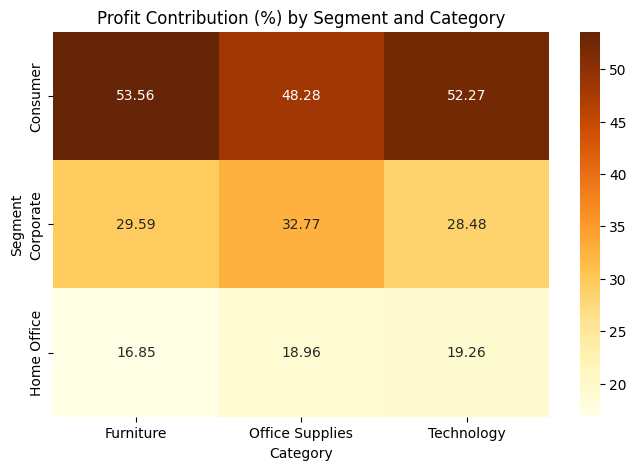

In [29]:
# Calculates and visualizes each customer segment's percentage contribution to category profits.
def profit_contribution_by_segment(engine):

    query = """
    SELECT c.Segment, p.Category, SUM(od.Profit) AS TotalProfit
    FROM Customers c
    JOIN Orders o ON c.CustomerID = o.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    JOIN Products p ON od.ProductID = p.ProductID
    GROUP BY c.Segment, p.Category;
    """
    
    df = pd.read_sql(query, engine)
    
    # Pivot table for percentage contribution
    pivot = df.pivot(index='Segment', columns='Category', values='TotalProfit')
    pivot_pct = pivot.div(pivot.sum(axis=0), axis=1) * 100
    
    print("Percentage contribution of each Segment per Category:")
    display(pivot_pct)
    
    # Heatmap visualization
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot_pct, annot=True, fmt=".2f", cmap="YlOrBr")
    plt.title("Profit Contribution (%) by Segment and Category")
    plt.show()

profit_contribution_by_segment(engine)


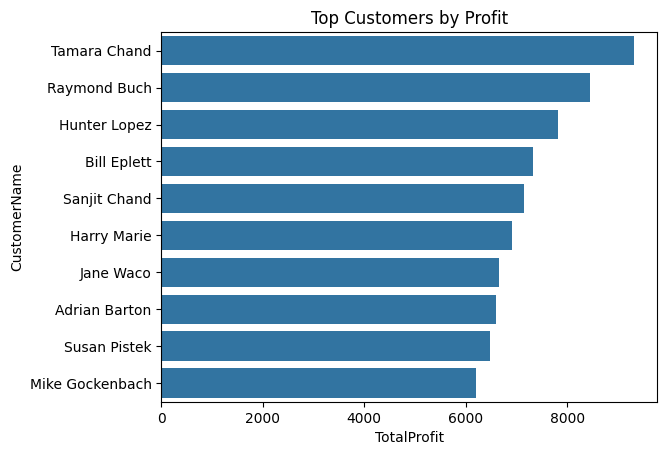

In [30]:
# Create a horizontal bar plot to visualize top customers by Total Profit
sns.barplot(data=top_customers, x='TotalProfit', y='CustomerName')
plt.title('Top Customers by Profit')
plt.show()

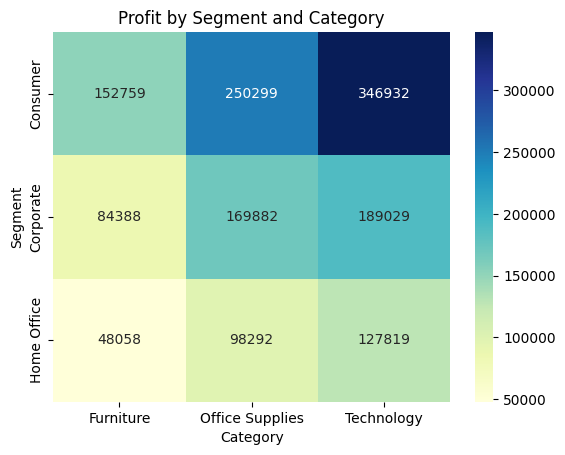

In [31]:
# Create a pivot table for visualization of TotalProfit by Segment and Category
pivot_table = df_segment_category.pivot(index='Segment', columns='Category', values='TotalProfit')

# Generate a heatmap to show profit distribution across Segments and Categories
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Profit by Segment and Category")
plt.show()

## Advanced Customer Segmentation: Exploring Patterns with K-Means and DBSCAN

In [32]:
# Load Customer Data
# Call stored procedure to get customer stats
df_customer_stats = pd.read_sql("CALL sp_TopCustomersByProfit(1000)", engine)

# Check data
print(df_customer_stats.columns)
df_customer_stats.head()

Index(['CustomerID', 'CustomerName', 'TotalProfit', 'TotalSales', 'NumOrders'], dtype='object')


,CustomerID,CustomerName,TotalProfit,TotalSales,NumOrders
0,TC-20980,Tamara Chand,9425.93,36259.89,28
1,RB-19360,Raymond Buch,8523.95,29197.65,25
2,BE-11335,Bill Eplett,7766.23,27134.80,36
3,HL-15040,Hunter Lopez,7654.53,29512.88,19
4,SC-20095,Sanjit Chand,7174.96,23250.92,25


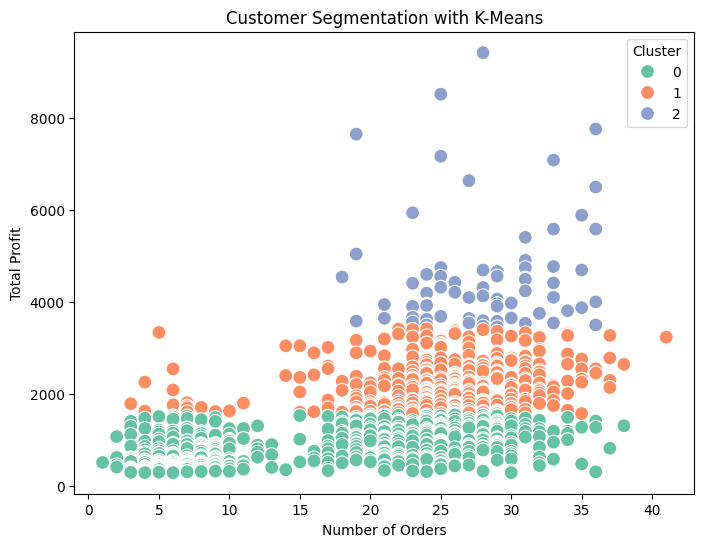

In [33]:
# K-Means Clustering
X_kmeans = df_customer_stats[['TotalProfit','NumOrders']].copy()

kmeans = KMeans(n_clusters=3, random_state=42)
df_customer_stats['KMeans_Cluster'] = kmeans.fit_predict(X_kmeans)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_customer_stats,
    x='NumOrders',
    y='TotalProfit',
    hue='KMeans_Cluster',
    palette='Set2',
    s=100
)
plt.title('Customer Segmentation with K-Means')
plt.xlabel('Number of Orders')
plt.ylabel('Total Profit')
plt.legend(title='Cluster')
plt.show()

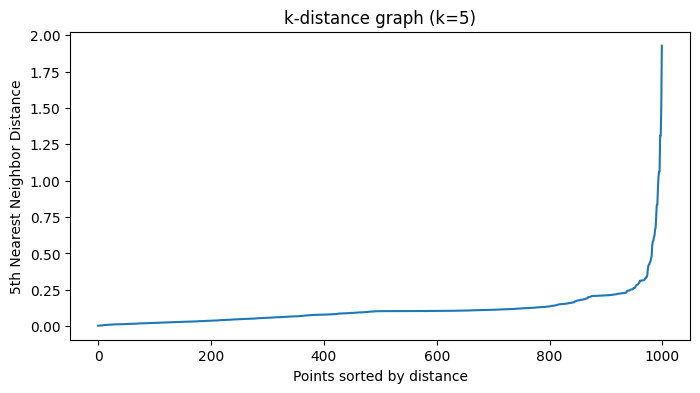

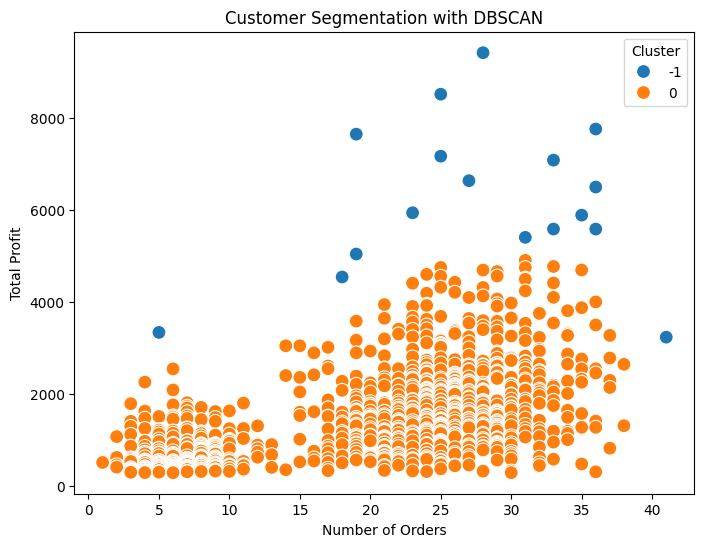

Silhouette Score not available (only one cluster or presence of noise).


In [41]:
# DBSCAN Clustering

# Scale the features - DBSCAN is distance-based, so scaling the data is important
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_customer_stats[['TotalProfit','NumOrders']])

# Plot k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances for visualization (look for "elbow")
distances = np.sort(distances[:,4])
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("k-distance graph (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()

# Run DBSCAN - Try different eps values (e.g. 0.3, 0.4, 0.5)
dbscan = DBSCAN(eps=0.4, min_samples=5)
df_customer_stats['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_customer_stats,
    x='NumOrders',
    y='TotalProfit',
    hue='DBSCAN_Cluster',
    palette='tab10',
    s=100
)
plt.title('Customer Segmentation with DBSCAN')
plt.xlabel('Number of Orders')
plt.ylabel('Total Profit')
plt.legend(title='Cluster')
plt.show()

# Evaluate clustering
# Silhouette Score: measures how well the data fits into clusters
# Score ranges from -1 (bad) to +1 (good). 
# Works only if there is more than 1 cluster.
labels = df_customer_stats['DBSCAN_Cluster']
if len(set(labels)) > 1 and -1 not in set(labels):  
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score not available (only one cluster or presence of noise).")

# Global Superstore Analysis – SQL & Python

## SQL Findings

- **Customers**
  - **Tamara Chand** – highest profit for the Superstore.  
  - **Patrick O'Brill** – most orders placed.  
  - **Consumers** – most profitable segment, especially in Technology.  

- **Products & Categories**
  - **Technology** and **Furniture** – top-performing categories.  
  - **Copiers** and **Phones** – subcategories with highest revenue.  
  - **Canon imageCLASS 2200 Advanced Copier** – highest revenue product.  
  - **Cubify CubeX 3D Printer Double Head Print** – lowest profit product.  

- **Sales & Geography**
  - **November 2024** – highest sales month.  
  - **September 2024** – highest profit month.  
  - **United States** – highest sales, followed by Turkey.  

## Machine Learning Insights (Python)

- **K-Means** – revealed distinct customer segments: high-value vs. low-engagement customers.  
- **DBSCAN** – detected outliers: unusually high profits or order volumes (potential VIPs or special attention accounts).  

## Conclusion

- SQL provided insights on key customers, top products, and sales/profit patterns over time and geography.  
- Python models added a behavioral perspective, highlighting customer segmentation and anomaly detection.  
- Next step: connect to Power BI to create interactive dashboards and support business decision-making.